In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 598ms/step - loss: 0.1880
Average validation loss: 0.5567476749420166
4/4 [==============================] - 6s 616ms/step - loss: 0.1880 - val_loss: 0.5567
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 614ms/step - loss: 0.1417 - val_loss: 0.5567
Average validation loss: 0.5778099298477173
4/4 [==============================] - 8s 630ms/step - loss: 0.1417 - val_loss: 0.5673
Epoch 3/10
4/4 [==============================] - 11s 638ms/step - loss: 0.1145 - val_loss: 0.5673
Average validation loss: 0.3949178457260132
4/4 [==============================] - 11s 654ms/step - loss: 0.1145 - val_loss: 0.5098
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_5.pth'.
Epoch 4/10
4/4 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 715ms/step - loss: 0.0096
Average validation loss: 1.3017550770655362e-07
8/8 [==============================] - 6s 727ms/step - loss: 0.0096 - val_loss: 1.3018e-07
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 766ms/step - loss: 0.0093 - val_loss: 1.3018e-07
Average validation loss: 0.0
8/8 [==============================] - 12s 783ms/step - loss: 0.0093 - val_loss: 6.5088e-08
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 714ms/step - loss: 0.0093 - val_loss: 6.5088e-08
Average validation loss: 0.0
8/8 [==============================] - 18s 729ms/step - loss: 0.0093 - val_loss: 4.3392e-08
Epoch 4/10
8/8 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 724ms/step - loss: 0.0123
Average validation loss: 0.18099482854207358
12/12 [==============================] - 9s 738ms/step - loss: 0.0123 - val_loss: 0.1810
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 719ms/step - loss: 0.0114 - val_loss: 0.1810
Average validation loss: 0.09709839443063857
12/12 [==============================] - 18s 734ms/step - loss: 0.0114 - val_loss: 0.1390
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 727ms/step - loss: 0.0111 - val_loss: 0.1390
Average validation loss: 0.12231698637693474
12/12 [==============================] - 27s 743ms/step - loss: 0.0111 - val_loss: 0.1335
Epoch 4/10
12/12 [======

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 722ms/step - loss: 0.0079
Average validation loss: 0.15917342938945422
16/16 [==============================] - 12s 735ms/step - loss: 0.0079 - val_loss: 0.1592
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 708ms/step - loss: 0.0080 - val_loss: 0.1592
Average validation loss: 0.03800028691875923
16/16 [==============================] - 23s 722ms/step - loss: 0.0080 - val_loss: 0.0986
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 728ms/step - loss: 0.0080 - val_loss: 0.0986
Average validation loss: 0.02944670981105446
16/16 [==============================] - 35s 741ms/step - loss: 0.0080 - val_loss: 0.0755
Saved model weights to

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 726ms/step - loss: 0.0057
Average validation loss: 0.03878956623375416
20/20 [==============================] - 15s 739ms/step - loss: 0.0057 - val_loss: 0.0388
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 718ms/step - loss: 0.0055 - val_loss: 0.0388
Average validation loss: 0.022483623377047478
20/20 [==============================] - 30s 731ms/step - loss: 0.0055 - val_loss: 0.0306
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 725ms/step - loss: 0.0055 - val_loss: 0.0306
Average validation loss: 0.09364481241166231
20/20 [==============================] - 44s 737ms/step - loss: 0.0055 - val_loss: 0.0516
Epoch 4/10
20/20 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 756ms/step - loss: 0.0073
Average validation loss: 0.06033488300939401
24/24 [==============================] - 18s 767ms/step - loss: 0.0073 - val_loss: 0.0603
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 36s 720ms/step - loss: 0.0063 - val_loss: 0.0603
Average validation loss: 0.032840329222381115
24/24 [==============================] - 36s 734ms/step - loss: 0.0063 - val_loss: 0.0466
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 707ms/step - loss: 0.0058 - val_loss: 0.0466
Average validation loss: 0.06889107388754685
24/24 [==============================] - 53s 721ms/step - loss: 0.0058 - val_loss: 0.0540
Epoch 4/10
24/24 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 713ms/step - loss: 0.0087
Average validation loss: 0.11503261141479015
40/40 [==============================] - 29s 726ms/step - loss: 0.0087 - val_loss: 0.1150
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 734ms/step - loss: 0.0078 - val_loss: 0.1150
Average validation loss: 0.030706152506172656
40/40 [==============================] - 59s 746ms/step - loss: 0.0078 - val_loss: 0.0729
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 88s 720ms/step - loss: 0.0073 - val_loss: 0.0729
Average validation loss: 0.08396234847605229
40/40 [==============================] - 88s 734ms/step - loss: 0.0073 - val_loss: 0.0766
Epoch 4/10
40/40 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 726ms/step - loss: 0.0060
Average validation loss: 0.09029831395794947
48/48 [==============================] - 36s 739ms/step - loss: 0.0060 - val_loss: 0.0903
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 720ms/step - loss: 0.0051 - val_loss: 0.0903
Average validation loss: 0.08233487466350198
48/48 [==============================] - 71s 732ms/step - loss: 0.0051 - val_loss: 0.0863
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 105s 716ms/step - loss: 0.0045 - val_loss: 0.0863
Average validation loss: 0.010652871138518094
48/48 [==============================] - 106s 729ms/step - loss: 0.0045 - val_loss: 0.0611
Saved model weights

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 727ms/step - loss: 0.0054
Average validation loss: 0.028149971539595038
56/56 [==============================] - 41s 739ms/step - loss: 0.0054 - val_loss: 0.0281
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 719ms/step - loss: 0.0045 - val_loss: 0.0281
Average validation loss: 0.08212455735539535
56/56 [==============================] - 82s 732ms/step - loss: 0.0045 - val_loss: 0.0551
Epoch 3/10
56/56 [==============================] - 123s 716ms/step - loss: 0.0039 - val_loss: 0.0551
Average validation loss: 0.0295884698483084
56/56 [==============================] - 123s 729ms/step - loss: 0.0039 - val_loss: 0.0466
Epoch 4/10
56/56 [==============================] - 163s 719ms/step - loss: 0.0035 - val_loss: 0.0466
Average validation loss: 0.03460686374981085
56/56 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 721ms/step - loss: 0.0042
Average validation loss: 0.01268385283765383
64/64 [==============================] - 47s 734ms/step - loss: 0.0042 - val_loss: 0.0127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 94s 732ms/step - loss: 0.0034 - val_loss: 0.0127
Average validation loss: 0.12943491339689928
64/64 [==============================] - 95s 745ms/step - loss: 0.0034 - val_loss: 0.0711
Epoch 3/10
64/64 [==============================] - 141s 723ms/step - loss: 0.0029 - val_loss: 0.0711
Average validation loss: 0.029857883811942543
64/64 [==============================] - 142s 736ms/step - loss: 0.0029 - val_loss: 0.0573
Epoch 4/10
64/64 [==============================] - 188s 725ms/step - loss: 0.0026 - val_loss: 0.0573
Average validation loss: 0.010082475302745308
64/64 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 718ms/step - loss: 0.0042
Average validation loss: 0.009320875836743249
72/72 [==============================] - 53s 730ms/step - loss: 0.0042 - val_loss: 0.0093
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 717ms/step - loss: 0.0033 - val_loss: 0.0093
Average validation loss: 0.009052214561961591
72/72 [==============================] - 105s 729ms/step - loss: 0.0033 - val_loss: 0.0092
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 728ms/step - loss: 0.0028 - val_loss: 0.0092
Average validation loss: 0.009880012936062284
72/72 [==============================] - 158s 740ms/step - loss: 0.0028 - val_loss: 0.0094
Epoch 4/10
72/7

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 60s 754ms/step - loss: 0.0045
Average validation loss: 0.012147507164627314
80/80 [==============================] - 61s 767ms/step - loss: 0.0045 - val_loss: 0.0121
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 124s 785ms/step - loss: 0.0035 - val_loss: 0.0121
Average validation loss: 0.025181298283860086
80/80 [==============================] - 125s 798ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 3/10
80/80 [==============================] - 188s 789ms/step - loss: 0.0029 - val_loss: 0.0187
Average validation loss: 0.007939295202959329
80/80 [==============================] - 189s 802ms/step - loss: 0.0029 - val_loss: 0.0151
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_100.pth'.
Epoch 4/10
80

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 70s 726ms/step - loss: 0.0054
Average validation loss: 0.021591018478867834
96/96 [==============================] - 71s 740ms/step - loss: 0.0054 - val_loss: 0.0216
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 141s 729ms/step - loss: 0.0041 - val_loss: 0.0216
Average validation loss: 0.02074199398542469
96/96 [==============================] - 142s 741ms/step - loss: 0.0041 - val_loss: 0.0212
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 212s 728ms/step - loss: 0.0034 - val_loss: 0.0212
Average validation loss: 0.026959594824532473
96/96 [==============================] - 213s 740ms/step - loss: 0.0034 - val_loss: 0.0231
Epoch 4/10
96/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 87s 722ms/step - loss: 0.0038
Average validation loss: 0.0071116208176439
120/120 [==============================] - 88s 734ms/step - loss: 0.0038 - val_loss: 0.0071
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 724ms/step - loss: 0.0032 - val_loss: 0.0071
Average validation loss: 0.005917219258844852
120/120 [==============================] - 176s 736ms/step - loss: 0.0032 - val_loss: 0.0065
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 263s 722ms/step - loss: 0.0027 - val_loss: 0.0065
Average validation loss: 0.007444435024323562
120/120 [==============================] - 265s 734ms/step - loss: 0.0027 - val_loss: 0.0068
Epo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 722ms/step - loss: 0.0031
Average validation loss: 0.0069539277927030225
144/144 [==============================] - 106s 735ms/step - loss: 0.0031 - val_loss: 0.0070
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 210s 722ms/step - loss: 0.0026 - val_loss: 0.0070
Average validation loss: 0.008460155589912872
144/144 [==============================] - 212s 735ms/step - loss: 0.0026 - val_loss: 0.0077
Epoch 3/10
144/144 [==============================] - 315s 721ms/step - loss: 0.0023 - val_loss: 0.0077
Average validation loss: 0.007608088907829824
144/144 [==============================] - 317s 734ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 4/10
144/144 [==============================] - 421s 720ms/step - loss: 0.0022 - val_loss: 0.0077
Average validation loss: 0.007519003534172144

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 116s 722ms/step - loss: 0.0022
Average validation loss: 0.030087295430712403
160/160 [==============================] - 118s 735ms/step - loss: 0.0022 - val_loss: 0.0301
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 233s 721ms/step - loss: 0.0019 - val_loss: 0.0301
Average validation loss: 0.05844510239548981
160/160 [==============================] - 235s 734ms/step - loss: 0.0019 - val_loss: 0.0443
Epoch 3/10
160/160 [==============================] - 351s 726ms/step - loss: 0.0017 - val_loss: 0.0443
Average validation loss: 0.096375143667683
160/160 [==============================] - 353s 738ms/step - loss: 0.0017 - val_loss: 0.0616
Epoch 4/10
160/160 [==============================] - 468s 720ms/step - loss: 0.0016 - val_loss: 0.0616
Average validation loss: 0.012391616148076424
160/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 145s 723ms/step - loss: 0.0052
Average validation loss: 0.013749561177100987
200/200 [==============================] - 147s 735ms/step - loss: 0.0052 - val_loss: 0.0137
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 292s 723ms/step - loss: 0.0041 - val_loss: 0.0137
Average validation loss: 0.012198512129780284
200/200 [==============================] - 294s 735ms/step - loss: 0.0041 - val_loss: 0.0130
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 439s 725ms/step - loss: 0.0034 - val_loss: 0.0130
Average validation loss: 0.017420619986951352
200/200 [==============================] - 442s 737ms/step - loss: 0.0034 - val_loss: 0.0145

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:46 - loss: 0.0010

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 722ms/step - loss: 0.0030
Average validation loss: 0.042797847517754124
240/240 [==============================] - 176s 734ms/step - loss: 0.0030 - val_loss: 0.0428
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 350s 723ms/step - loss: 0.0024 - val_loss: 0.0428
Average validation loss: 0.007592904900005208
240/240 [==============================] - 353s 735ms/step - loss: 0.0024 - val_loss: 0.0252
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_70\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 526s 722ms/step - loss: 0.0021 - val_loss: 0.0252
Average validation loss: 0.008074862404943758
240/240 [==============================] - 529s 734ms/step - loss: 0.0021 - val_loss: 0.0195

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.057704331056194054, 0.12493013098690316, 0.14356409749927068, 0.09028043553673819, 0.05036840631123895, 0.05672670293829789, 0.1002432993529859, 0.04386812338427574, 0.0514133423343717, 0.058307877702698116, 0.02964338221187467, 0.018868955619718502, 0.02852357265821699, 0.007653104582752365, 0.021384383601953626, 0.03881122029197165, 0.02278078898172128, 0.009481171976541023]
std_val_losses =  [0.12478774724831883, 0.13893461683613334, 0.09797415236136124, 0.06926014108266025, 0.037107253858248236, 0.06020688398414734, 0.10803978777017408, 0.04615234563436111, 0.053713178733161414, 0.10391587694888926, 0.06656726274336917, 0.029787149232775426, 0.0785832157767751, 0.006450320115967147, 0.038832460704556544, 0.1690747624142516, 0.0671056528744588, 0.01246669409270669]


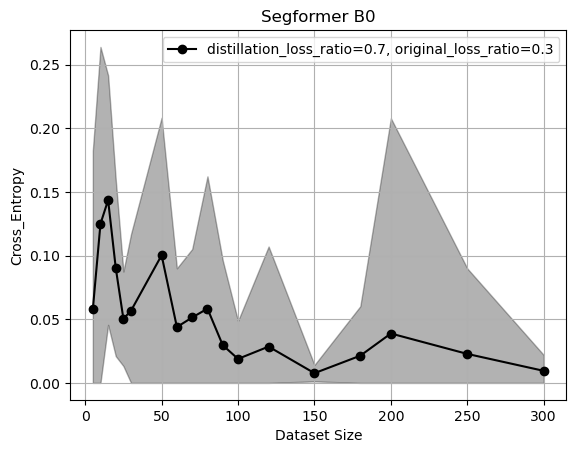

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()